In [ ]:
!pip install git+https://github.com/huggingface/datasets.git
!pip install git+https://github.com/huggingface/transformers.git
!pip install torchaudio
!pip install librosa
!pip install jiwer
!pip install ffmpeg-python

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);

function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import wave
from scipy.io.wavfile import read as wav_read
import io
import numpy as np
import ffmpeg

def write_wav(f, sr, x, normalized=False):
    f = wave.open(f, "wb")
    f.setnchannels(1)
    f.setsampwidth(2)
    f.setframerate(sr)
    
    wave_data = x.astype(np.short)
    f.writeframes(wave_data.tobytes())
    f.close()

def get_audio():
  global hnum

  # call microphone
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
      .input('pipe:0')
      .output('pipe:1', format='wav')
      .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]
  sr, audio = wav_read(io.BytesIO(riff))
  # save
  human_sound_file = "demo.wav"
  write_wav(human_sound_file, sr, audio)

  return human_sound_file

In [ ]:
import torchaudio
from datasets import load_dataset, load_metric
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    AutoTokenizer, 
    AutoModelWithLMHead 
)
import torch
import re
import sys

model_name = "voidful/wav2vec2-large-xlsr-53-tw-gpt"
device = "cuda"
processor_name = "voidful/wav2vec2-large-xlsr-53-tw-gpt"

chars_to_ignore_regex = r"[¥•＂＃＄％＆＇（）＊＋，－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､　、〃〈〉《》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏﹑﹔·'℃°•·．﹑︰〈〉─《﹖﹣﹂﹁﹔！？｡。＂＃＄％＆＇（）＊＋，﹐－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》「」『』【】〔〕〖〗〘〙〚〛〜〝〞〟〰〾〿–—‘’‛“”„‟…‧﹏.．!\"#$%&()*+,\-.\:;<=>?@\[\]\\\/^_`{|}~]"

model = Wav2Vec2ForCTC.from_pretrained(model_name).to(device)
processor = Wav2Vec2Processor.from_pretrained(processor_name)

tokenizer = AutoTokenizer.from_pretrained("ckiplab/gpt2-base-chinese")  
gpt_model = AutoModelWithLMHead.from_pretrained("ckiplab/gpt2-base-chinese").to(device)


Decoding with language model adjustment

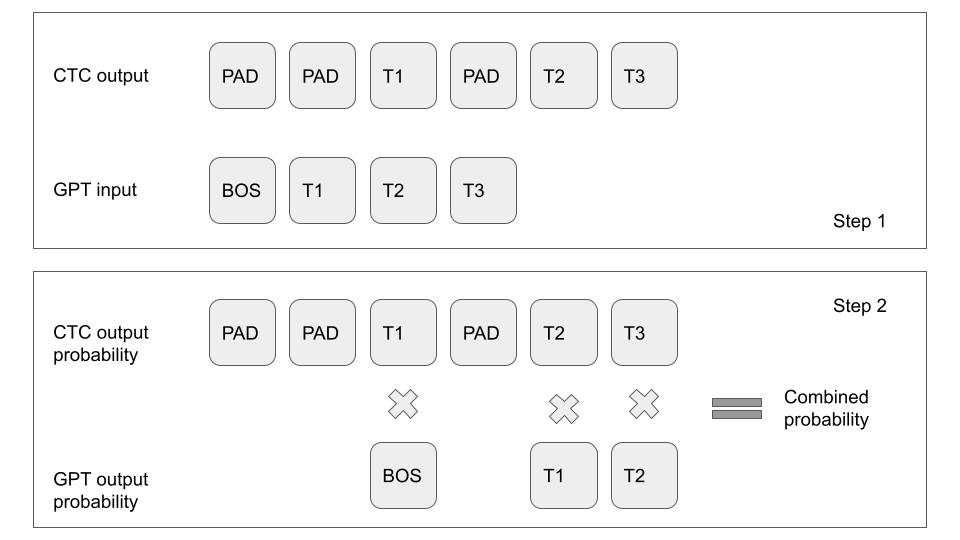

In [ ]:
resampler = torchaudio.transforms.Resample(orig_freq=48_000, new_freq=16_000)

def load_file_to_data(file):
    batch = {}
    speech, _ = torchaudio.load(file)
    batch["speech"] = resampler.forward(speech.squeeze(0)).numpy()
    batch["sampling_rate"] = resampler.new_freq
    return batch

def predict(data):
    features = processor(data["speech"], sampling_rate=data["sampling_rate"], padding=True, return_tensors="pt")
    input_values = features.input_values.to(device)
    attention_mask = features.attention_mask.to(device)
    with torch.no_grad():
        logits = model(input_values, attention_mask=attention_mask).logits
    
    decoded_results = []
    for logit in logits:
        pred_ids = torch.argmax(logit, dim=-1)
        mask = pred_ids.ge(1).unsqueeze(-1).expand(logit.size())
        vocab_size = logit.size()[-1]
        voice_prob = torch.nn.functional.softmax((torch.masked_select(logit, mask).view(-1,vocab_size)),dim=-1)
        gpt_input = torch.cat((torch.tensor([tokenizer.cls_token_id]).to(device),pred_ids[pred_ids>0]), 0)
        gpt_prob = torch.nn.functional.softmax(gpt_model(gpt_input).logits, dim=-1)[:voice_prob.size()[0],:]
        comb_pred_ids = torch.argmax(gpt_prob*voice_prob, dim=-1)
        decoded_results.append(processor.decode(comb_pred_ids))

    return decoded_results


In [ ]:
get_audio()

In [ ]:
predict(load_file_to_data('./demo.wav'))